# DSSATTools Example 3: paralel simulations using threading

In this notebook you'll see the basic usage of DSSATools library to:
1. Create the inputs
2. Initialize the simulation environment
3. Run simulations in paralel
4. Modify input objects
5. Read outputs.

We'll use threading to run simulations in paralel. If you prefer to use Multiprocessing, i.e. different cores, the process is different since multiprocessing does not allows the modification of an instance.

In [1]:
from DSSATTools import (Crop, SoilProfile, Weather, Management, DSSAT, TabularSubsection)
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import threading
import os
from matplotlib import pyplot as plt
from copy import deepcopy

## Create a WeatherData instance

In [2]:
# Random weather data
DATES = pd.date_range('2008-01-01', '2010-12-31')
N = len(DATES)
df = pd.DataFrame(
    {
    'tn': np.random.gamma(10, 1, N),
    'rad': np.random.gamma(10, 1.5, N),
    'prec': [0.0]* N,
    'rh': 100 * np.random.beta(1.5, 1.15, N),
    },
    index=DATES,
)
df['TMAX'] = df.tn + np.random.gamma(5., .5, N)
# Create a WheaterStation instance
wth = Weather(
    df, 
    {'tn': 'TMIN', 'TMAX': 'TMAX', 'prec': 'RAIN', 
     'rad': 'SRAD', 'rh': 'RHUM'}, 4.3434237,-74.3606715, 1800
)
wth

Weather data at -74.361°, 4.343°
  Date start: 2008-01-01
  Date end: 2010-12-31
Average values:
TMAX    12.544305
TMIN    10.033416
RAIN     0.000000
SRAD    14.795555
RHUM    56.299164
dtype: float64

## Create a SoilProfile object from a default profile

In [3]:
# Soil instance from default soil profile
soil = SoilProfile(default_class='SICL')

## Create crop objects for different cultivars

In [4]:
# Crop
cultivar_names = ["990001", "990002", "990003", "990004"]
crops = {cultivar: Crop("sorghum", cultivar) for cultivar in cultivar_names}
crops

{'990001': Sorghum crop, N.AMERICAN       cultivar,
 '990002': Sorghum crop, INDIAN           cultivar,
 '990003': Sorghum crop, AUSTRALIAN       cultivar,
 '990004': Sorghum crop, W.AFRICAN        cultivar}

## Initialize one DSSAT instance per thread

In [5]:
dssat_envs = []
threads = len(crops)
for n in range(threads):
    dssat_envs.append(DSSAT())
    dssat_envs[-1].setup()

/tmp/dssatkbiumqbz created.
Static files copied to /tmp/dssatkbiumqbz.
/tmp/dssatzzvcygor created.
Static files copied to /tmp/dssatzzvcygor.
/tmp/dssatlbbqegoq created.
Static files copied to /tmp/dssatlbbqegoq.
/tmp/dssatetitmezo created.
Static files copied to /tmp/dssatetitmezo.


## Run with different management

In [6]:
# Create a wrap funciton to run the model
def run_dssat(thread, cultivar, man):
    dssat_envs[thread].run(
        crop=crops[cultivar], weather=wth, management=man, soil=soil
    )

In [7]:
# processes list
processes = []
# A dict to map each core run to its cultivar
cultivar_maping = {thread: '' for thread in range(threads)}
output = {} # To save the outputs
man = Management(
    planting_date=DATES[10],
    irrigation='A' # Automatic Irrigation
)
man.simulation_controls['HARVS'] = 'M'
current_thread = 0
for cultivar in cultivar_names:
    management = deepcopy(man) # It has to be deepcopied as each instance is associated with different simulations
    processes.append(
        threading.Thread(target=run_dssat, args=(current_thread, cultivar, management))
    )
    cultivar_maping[current_thread] = cultivar
    processes[-1].start()
    current_thread += 1
    # Wait until all of the processes are finished
    if (current_thread == threads) or (cultivar == cultivar_names[-1]):
        for p in processes: p.join()
        for thread, cul in cultivar_maping.items():
            output[cul] = dssat_envs[thread].output['PlantGro']
        current_thread = 0
        processes = []

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SG   1 380 410 15382  2873     0   794   827   105     0   -99      0  122
RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SG   1 349 367 13682  1746     0   715   735   117     0   -99      0  123
RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SG   1 345 363 13631  2144     0   689   725   102     0   -99      0  123
RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SG   1 351 371 13764  2045     0   713   742   109     0   -99      0  123


In [8]:
# Close all of the DSSAT instances
for dssat in dssat_envs: dssat.close()

/tmp/dssatkbiumqbz and its content has been removed.
/tmp/dssatzzvcygor and its content has been removed.
/tmp/dssatlbbqegoq and its content has been removed.
/tmp/dssatetitmezo and its content has been removed.


## Check the results for the yield

Text(0, 0.5, 'Yield (Kg/ha)')

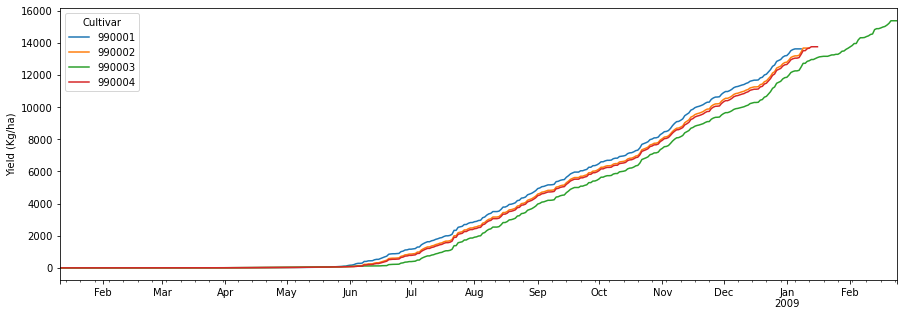

In [9]:
fig, ax = plt.subplots(figsize=(15, 5))
for cultivar, df in output.items():
    df.CWAD.plot(ax=ax, label=cultivar)
ax.legend(title='Cultivar')
ax.set_ylabel('Yield (Kg/ha)')